In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from collections import Counter
import math
import scipy.stats as stats
import statistics
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings( "ignore" )
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
#preprocessing
data = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col =  ["treatment", "y_factual", "y_cfactual",]
for i in range(1,28):
    col.append("x"+str(i))
data.columns = col
#data.head()
x_data_comp=pd.concat([data.iloc[:,0], data.iloc[:, 1:30]], axis = 1)
y_data_comp=data.iloc[:, 1]

In [3]:
#function for k-s test
def ks_w2(data1, data2, wei1, wei2):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1) / sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2) / sum(wei2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]
    return np.max(np.abs(cdf1we - cdf2we))

In [4]:
#function to compute p-vale
def ks_w2_p(data1, data2, wei1, wei2):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1) / sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2) / sum(wei2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]
    a=stats.ttest_ind(a=cdf1we, b=cdf2we, equal_var=False)
    return a[1]

In [5]:
#function to estimate k-s test with p-vale percentage

list_of_p_os = []
list_of_p_ipw = []
list_of_p_unw = []
for i in range(6):
  list_of_p_os.append([])
  list_of_p_ipw.append([])
  list_of_p_unw.append([])

def ks_cal(model_type):
  KS_weights=np.zeros(6)
  KS_ipw=np.zeros(6)
  KS_unw=np.zeros(6)
  for i in range(1,200):
    x_train, x_test, y_train, y_test = train_test_split(x_data_comp, y_data_comp, test_size=0.20, random_state=i)
    #X_train_t=x_train.iloc[:, 2:30]
    X_train_t=x_train.iloc[:, 5:30]
    Y_train_t=x_train.iloc[:, 0]
    X_test_t=x_test.iloc[:, 5:30]
    Y_test_t=x_test.iloc[:, 0]
    if(model_type==0):
       model = LogisticRegression(max_iter=2)
    elif(model_type==1):
       model = LogisticRegression()
    else:
      model = lgb.LGBMClassifier()

    model.fit(X_train_t, Y_train_t)
    expected_y  = Y_test_t
    expected_yt  = Y_train_t
    predicted_y =model.predict(X_test_t)
    predicted_yt=model.predict(X_train_t)
    probs=model.predict_proba(X_test_t)
    data_probs = x_test[['treatment','y_cfactual']]



    data_probs.loc[:,['P0','P1']] = probs
    data_probs['ipw']= np.where (data_probs['treatment']==1, 1/data_probs['P1'], 1/data_probs['P0'])
    data_probs['e']= np.where (data_probs['treatment']==1, 1-data_probs['P1'], 1-data_probs['P0'])
    data_probs.loc[:, 'ep'] =(data_probs.loc[:, 'e'])

    weightsn = np.array(data_probs['ep'])
    invweightsn = np.array(data_probs['ipw'])
    data_treat=x_test[x_test['treatment']==1]
    data_control=x_test[x_test['treatment']==0]

    treat_weights=np.array(data_probs.loc[data_probs['treatment']==1,'ep'])
    control_weights=np.array(data_probs.loc[data_probs['treatment']==0,'ep'])
    treat_ipw=np.array(data_probs.loc[data_probs['treatment']==1,'ipw'])
    control_ipw=np.array(data_probs.loc[data_probs['treatment']==0,'ipw'])

    ind=0
    for k in range(3,9):
      #col.append("x"+str(i))
      x='x'+str(k)
      KS_weights[ind]=KS_weights[ind]+ks_w2(np.array(data_treat[x]),np.array(data_control[x]),treat_weights,control_weights)
      list_of_p_os[ind].append(ks_w2_p(np.array(data_treat[x]),np.array(data_control[x]),treat_weights,control_weights))
      KS_ipw[ind]=KS_ipw[ind]+ks_w2(np.array(data_treat[x]),np.array(data_control[x]),treat_ipw,control_ipw)
      list_of_p_ipw[ind].append(ks_w2_p(np.array(data_treat[x]),np.array(data_control[x]),treat_ipw,control_ipw))
      treat_ones=np.ones(len(np.array(data_treat[x])))
      control_ones=np.ones(len(np.array(data_control[x])))
      KS_unw[ind]= KS_unw[ind]+ks_w2(np.array(data_treat[x]),np.array(data_control[x]),treat_ones,control_ones)
      list_of_p_unw[ind].append(ks_w2_p(np.array(data_treat[x]),np.array(data_control[x]),treat_ones,control_ones))
      ind=ind+1

  KS_weights=(KS_weights/200)
  KS_ipw=(KS_ipw/200)
  KS_unw=(KS_unw/200)
  return KS_weights,KS_ipw,KS_unw

In [6]:
#0 =underfit, 1=moderate, 2=overfit
model_type=1
KS_weights,KS_ipw,KS_unw=ks_cal(model_type)
if(model_type==0):
  typeis='underfit'
elif(model_type==1):
  typeis='good'
else:
  typeis='overfit'

print('K-S weights OS',KS_weights)
print('sum of K-S weights OS',sum(KS_weights))
print ('Percentage of p-vale>0.05 for all features')
print ('-----------------------------------------')
for i in range(6):
  count = sum(map(lambda x : x>0.05, list_of_p_os[i]))
  #print(len(list_of_p_os))
  print(count/len(list_of_p_os[i]))

K-S weights OS [0.18063053 0.15426852 0.16412755 0.11995157 0.18255494 0.16378079]
sum of K-S weights OS 0.9653139021496533
Percentage of p-vale>0.05 for all features
-----------------------------------------
0.6834170854271356
0.7236180904522613
0.6633165829145728
0.35678391959798994
0.5829145728643216
0.7135678391959799


In [7]:
def get_keys(val,dic):
    list=[]
    for key, value in dic.items():
        if val == value:
           list.append(key)
    return list

In [8]:
testdata_size = {}
for i in range(1000):
  x_train, x_test, y_train, y_test = train_test_split(x_data_comp, y_data_comp, test_size=0.20, random_state=i)
  data_treat=x_test[x_test['treatment']==1]
  data_control=x_test[x_test['treatment']==0]
  testdata_size[i]=len(data_treat)
value, count = Counter(testdata_size.values()).most_common(1)[0]
list_of_seeds=get_keys(value,testdata_size)

In [9]:
#function to estimate ECDF
X_Result_treat=[]
Y_Result_treat=[]
X_Result_control=[]
Y_Result_control=[]

def ecdf_cal(scheme):
  for i in list_of_seeds:
    x_train, x_test, y_train, y_test = train_test_split(x_data_comp, y_data_comp, test_size=0.20, random_state=i)
    #X_train_t=x_train.iloc[:, 2:30]
    X_train_t=x_train.iloc[:, 5:30]
    Y_train_t=x_train.iloc[:, 0]
    X_test_t=x_test.iloc[:, 5:30]
    Y_test_t=x_test.iloc[:, 0]
    model = LogisticRegression()
    model.fit(X_train_t, Y_train_t)
    expected_y  = Y_test_t
    expected_yt  = Y_train_t
    predicted_y =model.predict(X_test_t)
    predicted_yt=model.predict(X_train_t)
    probs=model.predict_proba(X_test_t)
    data_probs = x_test[['treatment','y_cfactual']]



    data_probs.loc[:,['P0','P1']] = probs
    data_probs['ipw']= np.where (data_probs['treatment']==1, 1/data_probs['P1'], 1/data_probs['P0'])
    data_probs['e']= np.where (data_probs['treatment']==1, 1-data_probs['P1'], 1-data_probs['P0'])
    #data_probs.loc[:, 'ep'] = np.power(data_probs.loc[:, 'e'],p)
    data_probs.loc[:, 'ep'] =(data_probs.loc[:, 'e'])

    weightsn = np.array(data_probs['ep'])
    invweightsn = np.array(data_probs['ipw'])
    data_treat=x_test[x_test['treatment']==1]
    data_control=x_test[x_test['treatment']==0]

    treat_weights=np.array(data_probs.loc[data_probs['treatment']==1,'ep'])
    control_weights=np.array(data_probs.loc[data_probs['treatment']==0,'ep'])
    treat_ipw=np.array(data_probs.loc[data_probs['treatment']==1,'ipw'])
    control_ipw=np.array(data_probs.loc[data_probs['treatment']==0,'ipw'])

    feature_treat_x=[]
    feature_treat_y=[]
    feature_control_x=[]
    feature_control_y=[]

    for k in range(3,9):
      #col.append("x"+str(i))
      x='x'+str(k)
      if(scheme==0):
        sns.ecdfplot(data=data_treat,y=x,weights=treat_weights )
        sns.ecdfplot(data=data_control,y=x,weights=control_weights)
      elif(scheme==1):
        sns.ecdfplot(data=data_treat,y=x,weights=treat_ipw )
        sns.ecdfplot(data=data_control,y=x,weights=control_ipw)
      else:
        sns.ecdfplot(data=data_treat,y=x)
        sns.ecdfplot(data=data_control,y=x)

      ax = plt.gca()
      treat = ax.lines[0]
      control=ax.lines[1]
      #x_data=treat.get_xdata()
      feature_treat_x.append(treat.get_xdata())
      feature_treat_y.append(treat.get_ydata())
      feature_control_x.append(control.get_xdata())
      feature_control_y.append(control.get_ydata())
      plt.close()
    X_Result_treat.append(feature_treat_x)
    Y_Result_treat.append(feature_treat_y)
    X_Result_control.append(feature_control_x)
    Y_Result_control.append(feature_control_y)

In [10]:
# OS=0, IPW=1, unweighted=2
scheme=0
ecdf_cal(scheme)
if(scheme==0):
  typeis='Our scheme'
elif(scheme==1):
  typeis='IPW'
else:
  typeis='Without weights'

#Avg of estimated ECDF
X_Result_treat_avg=[]
Y_Result_treat_avg=[]
X_Result_control_avg=[]
Y_Result_control_avg=[]

for i in range(0,6):
  column = i
  X_Result_treat_avg.append(sum(row[column] for row in X_Result_treat)/len(list_of_seeds))
  Y_Result_treat_avg.append(sum(row[column] for row in Y_Result_treat)/len(list_of_seeds))
  X_Result_control_avg.append(sum(row[column] for row in X_Result_control)/len(list_of_seeds))
  Y_Result_control_avg.append(sum(row[column] for row in Y_Result_control)/len(list_of_seeds))



Text(0.5, 1.0, 'ECDF weighted (Our scheme) on birth weight')

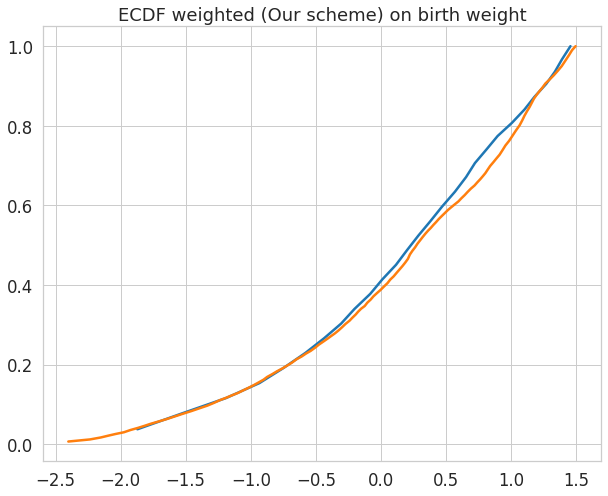

In [11]:
#plot of avg estimated ECDF
plt.plot(Y_Result_treat_avg[0],X_Result_treat_avg[0])
plt.plot(Y_Result_control_avg[0],X_Result_control_avg[0])
plt.title('ECDF weighted ('+typeis +') on birth weight')

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on birth head')

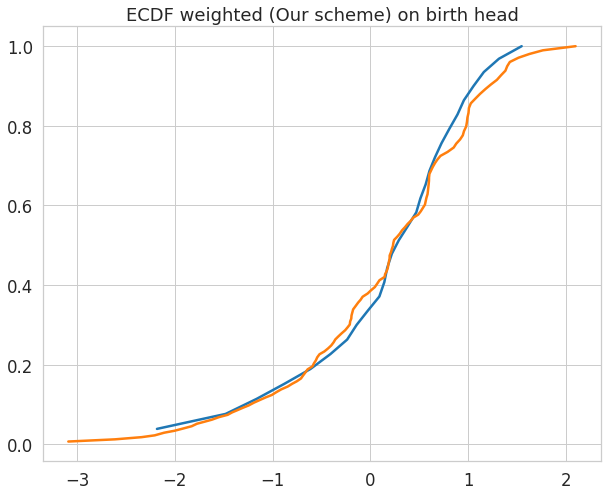

In [12]:
plt.plot(Y_Result_treat_avg[1],X_Result_treat_avg[1])
plt.plot(Y_Result_control_avg[1],X_Result_control_avg[1])
plt.title('ECDF weighted ('+typeis +') on birth head')

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on preterm')

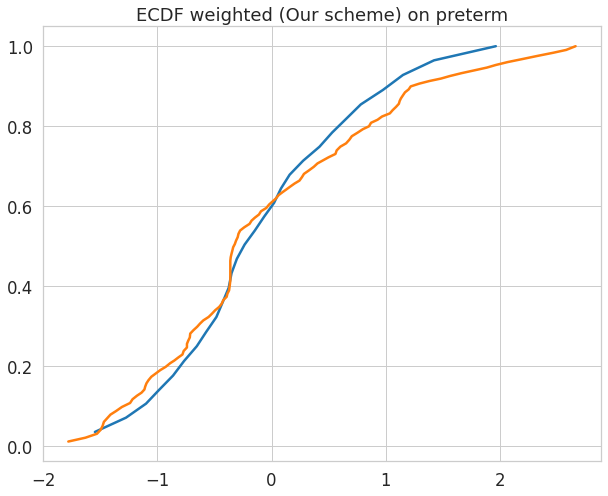

In [13]:
plt.plot(Y_Result_treat_avg[2],X_Result_treat_avg[2])
plt.plot(Y_Result_control_avg[2],X_Result_control_avg[2])
plt.title('ECDF weighted ('+typeis +') on preterm')

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on birth order')

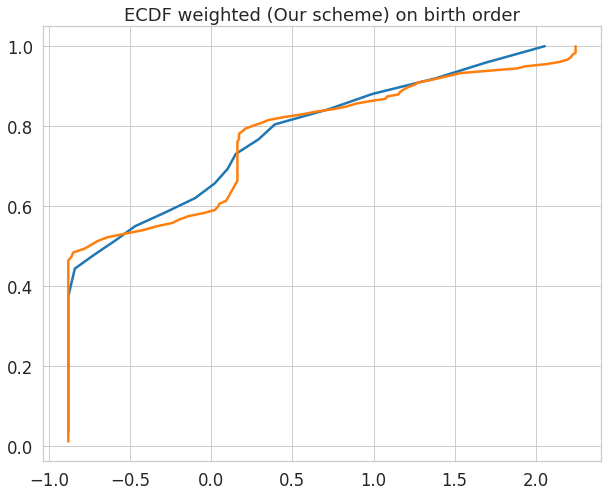

In [14]:
plt.plot(Y_Result_treat_avg[3],X_Result_treat_avg[3])
plt.plot(Y_Result_control_avg[3],X_Result_control_avg[3])
plt.title('ECDF weighted ('+typeis +') on birth order')

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on nnhealth')

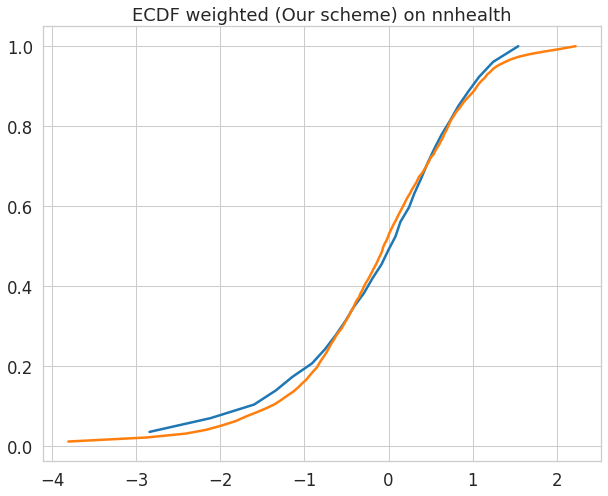

In [15]:
plt.plot(Y_Result_treat_avg[4],X_Result_treat_avg[4])
plt.plot(Y_Result_control_avg[4],X_Result_control_avg[4])
plt.title('ECDF weighted ('+typeis +') on nnhealth')

Text(0.5, 1.0, 'ECDF weighted (Our scheme) on mom age')

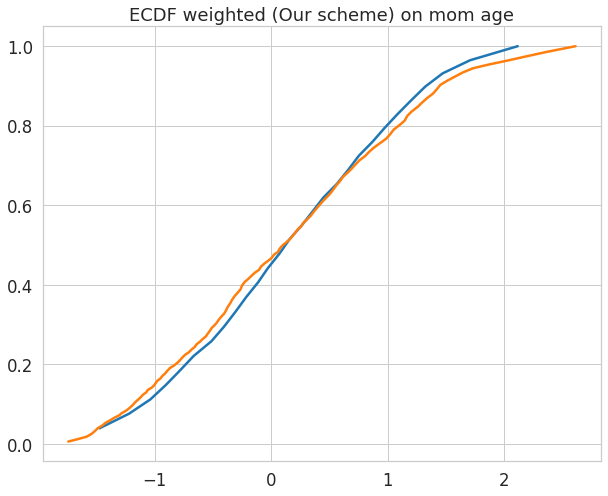

In [16]:
plt.plot(Y_Result_treat_avg[5],X_Result_treat_avg[5])
plt.plot(Y_Result_control_avg[5],X_Result_control_avg[5])
plt.title('ECDF weighted ('+typeis +') on mom age')